# Assessing the ICON-ModEx ML models

## Motivation
With the respiration rate data spanning many orders of magnitude, it would seem like a good idea to apply a log10 (or other transform) on the target (i.e. the respiration rate) with the TransformedTargetRegressor option in the `scikit-learn` models. All trained ML models with this built-in, optional transformer will automatically read in data, transform it, train or predict, and then apply the inverse transform. "Baking in" the transformer to the ML model means that whoever uses the model later does not need to go through the process of applying the transformer.

In an ideal world, we could use the [Yeo-Johnson transform](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html) because it does a good job handling a variety of cases.  In practice however, coupling the YJ transform (and other power transformers) to the hyperparameter optimization implemented within the SuperLeaner results in lots of internal NaN values that cause training to crash.  My guess is that the wide range of hyperparameters that we search through may result in lots of intermediate off-the-wall values that the YJ transform is not prepared to handle.

So, in practice, I implemented my own [log10 transform/inverse](https://github.com/parallelworks/sl_core/blob/main/sample_inputs/superlearner_conf_TTR_mms_log10_neg.py) that uses both the log10 and **hard coded** (CAUTION!!!) limits to a MinMaxScaler for the WHONDRS data set. Since the MinMaxScaler is applied **after** the log10, this means that the MinMaxScaler limits `[-2.0,4.0]` are orders of magnitude (i.e. 0.01 to 10000), not actual values. This notebook is designed to check how this log10 transformation performs compared to the standard approach which uses only (automated range) MinMaxScalers.

Furthermore, neither the YJ or custom transformer discussed above will map a bimodal distribution to a unimodal distribution. In general, ML models perform well when the inputs and outputs are similar to Gaussian (unimodal) distributions. As such, we also test here the [QuantileTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html) because this transformer can map bimodal distributions to Guassian (unimodal). However, it is likely that we don't have enough data to properly train this transformer so the results here are likely not generalizable to other data sets.

A very nice, general graphical comparision between various transformers is [linked here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_map_data_to_normal.html) and a practical example of why you want to consider a transformer is [linked here](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html).

## Important behind the scenes information
Here, I am assuming that this notebook is running in a Linux context (e.g. pull a [container that runs a local Jupyter server](https://hub.docker.com/r/jupyter/datascience-notebook) and open the notebook therein). This code will switch branches within a repository that it downloads from GitHub to load the data for side by side comparisions. It will then delete the source repository and retain only the harvested data used for plotting. The harvested data will be saved alongside this notebook here. 

## Does Reducing Features Help with Bias?

Look at different FPI cutoffs to see if reducing the number of features changes bias

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis
from scipy.stats import skew
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

org='parallelworks'
repo = "sl-archive-whondrs"

# Number of independent SuperLearners
num_sl = 10

# Number of histogram bins
num_bins = 25

# Large/small respiration boundary value
rr_bnd = -500.0

# Function to return the percent of positive 
# values in a given dataframe column
def get_percent_positive(df_in,target_name='Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'):
    num_pos = np.shape(
        df_in[df_in[target_name] > 0])[0]
    num_all = np.shape(df_in)[0]
    return 100.0*num_pos/num_all

## Grab data
The predict data are predictions of `Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment` at sites where we do not have any observations of respiration rate.  The `_CONUS` predictions are spatially filtered to just the continental US.

The train and test data were generated during the running of the SuperLearner's `predict.py` stage; the ML model is already trained and the ML model is being used to predict respiration rates at the sites we already have observations. The training set are the data used to train the ML model while the testing set was split off from the data set before training the ML model. Each SuperLearner ensemble member has a slightly different train/test split. Train and test data are all respiration rates; the `target` column is the observed value and the `predicted` column is the corresponding prediction at that site. These data sets are a concatenation of the train/test target/predicted values over all SuperLearner instances trained for a particular ModEx iteration. Since the SuperLearners are all a little different, there should be no duplicate values in the `predicted` column while there will be duplicated values (exactly `num_sl` duplicates for each value, default is 10) in the `target` column.

Updating files: 100% (372/372), done.
Switched to branch 'Summer-2019-log10-fpi90-r01-results'
Your branch is up to date with 'origin/Summer-2019-log10-fpi90-r01-results'.
Updating files: 100% (305/305), done.
Switched to branch 'Summer-2019-log10-r08'
Your branch is up to date with 'origin/Summer-2019-log10-r08'.
Updating files: 100% (306/306), done.
Switched to branch 'Summer-2019-log10-r04'
Your branch is up to date with 'origin/Summer-2019-log10-r04'.
Updating files: 100% (306/306), done.
Switched to branch 'Summer-2019-log10-r07'
Your branch is up to date with 'origin/Summer-2019-log10-r07'.
Updating files: 100% (305/305), done.
Switched to branch 'Summer-2019-log10-r01'
Your branch is up to date with 'origin/Summer-2019-log10-r01'.


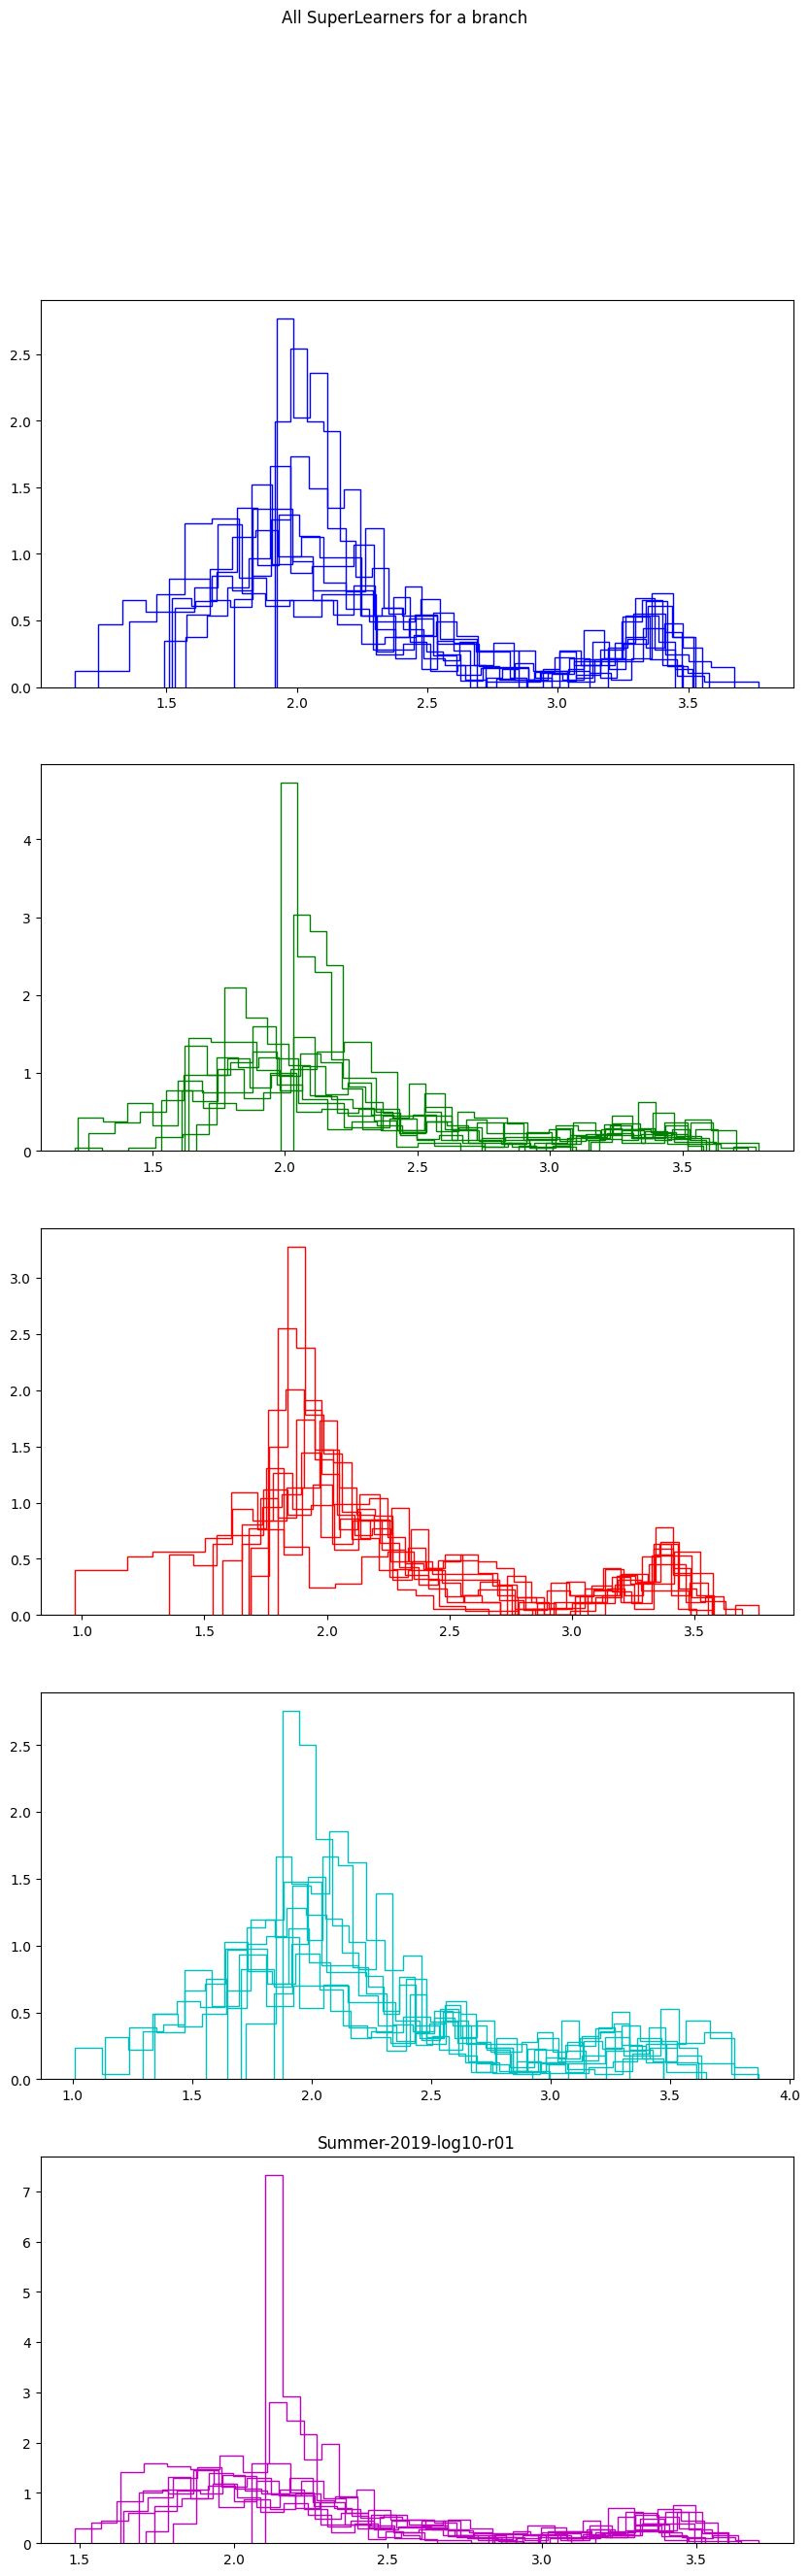

In [2]:
# remove previous csv files

# List the branches we want to work with
list_branches = ["Summer-2019-log10-fpi90-r01-results", "Summer-2019-log10-r08", "Summer-2019-log10-r04", "Summer-2019-log10-r07", "Summer-2019-log10-r01"]
# Summer-2019-log10-fpi90-r01-results: fpi .9
# Summer-2019-log10-r08: fpi .9
    # Got rid of duplicate NPOC data.
# Summer-2019-log10-r04: fpi .7
# Summer-2019-log10-r07: fpi .7
    # Got rid of duplicate NPOC data.
# Summer-2019-log10-r01: fpi .5
branch_colors = ['b', "g", "r", "c", "m"]

# Start a figure for plotting histograms
fig, ax = plt.subplots(len(list_branches), 1, figsize=(10,30))
fig.suptitle("All SuperLearners for a branch")

for bb,branch in enumerate(list_branches):
    
    # Change to the requested branch
    !git checkout {branch}
    
    # Loop over the ensemble of SuperLearners
    for ll in range(0,num_sl):
        
        predict = pd.read_csv('ml_models/sl_'+str(int(ll))+'/sl_predictions.csv')
        
        # Grab general predict
        predict_input = pd.read_csv('scripts/prep_06_output_final_predict.csv')

        if (ll == 0):
            # Load the first Superlearner to initialize storage
            predict_all = predict
        else:
            # Append data for the other SuperLearners
            predict_all = pd.concat([predict_all, predict])

        # Histogram with all superlearners for one branch in one graph
        plt.gca().set_title(branch)
        n, bins, patches = ax[bb].hist(
           np.log10(np.abs(predict['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])),
           num_bins, density=True, histtype="step", linestyle=('solid'), color=(branch_colors[bb]))
    
    # Done loading raw data from each SuperLearner instance
    # Now, write output to files for publication-quality plots
    # Use the two hyphen naming convention to separate
    # branch name from file type.
    predict_all.to_csv(branch+'--predict_all.csv',mode='w')


 
-----> Working on data from branch: Summer-2019-log10-fpi90-r01-results
 
Percent positive in predict_all: 0.0
 
-----> Working on data from branch: Summer-2019-log10-r08
 
Percent positive in predict_all: 0.0
 
-----> Working on data from branch: Summer-2019-log10-r04
 
Percent positive in predict_all: 0.0
 
-----> Working on data from branch: Summer-2019-log10-r07
 
Percent positive in predict_all: 0.0
 
-----> Working on data from branch: Summer-2019-log10-r01
 
Percent positive in predict_all: 0.0


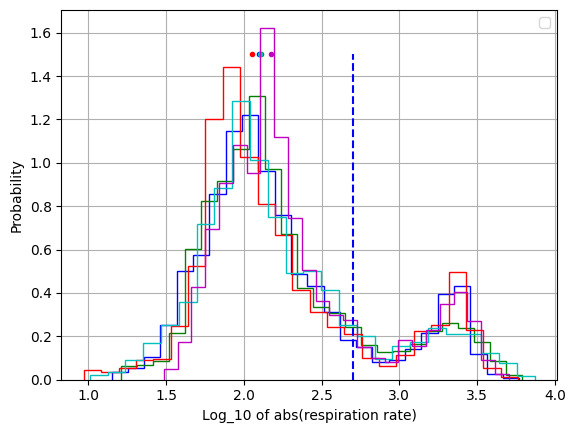

In [3]:
# Above we plotted each SuperLearner iteration separately.
# Now, plot the overall, merged distributions.

# Initialize the figure
fig, ax = plt.subplots(1,1)

# Initialize a list of lines' names to be drawn
legend_list = []

for bb,branch in enumerate(list_branches):
    
    print(' ')
    print('-----> Working on data from branch: '+branch)
    
    # Load consolidated data
    predict_all = pd.read_csv(branch+'--predict_all.csv')
    
    # Write out a summary of the data
    print(' ')
    print('Percent positive in predict_all: '+str(get_percent_positive(predict_all)))

    # We want to see whether the ML model makes bimodal predictions "at scale"
    # (with many predictions) - but we cannot access the accuracy of this result
    # since there are no observed values to compare to.
    n, bins, patches = ax.hist(
       np.log10(np.abs(predict_all['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])),
       num_bins, density=True, histtype="step", 
       linestyle=('solid'), color=(branch_colors[bb]))
    
    # Plot the median for each histogram
    ax.plot([
        np.median(np.log10(np.abs(predict_all['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])))],
        [1.5],branch_colors[bb]+'.',label='_nolegend_')

# Add the line for visualizing where the cut off is:
ax.plot([np.log10(np.abs(rr_bnd)),np.log10(np.abs(rr_bnd))],[0,1.5],'b--')

# Labels
ax.set_ylabel('Probability')
ax.set_xlabel('Log_10 of abs(respiration rate)')
ax.grid()
ax.legend(legend_list)

**Figure 1:** Histograms of the observed training data respiration rates (dashed, i.e. the "truth"), the predicted respiration rates in the testing data (bold, i.e. the "classical" test of the ML models), and the predicted respiration rates over the CONUS at sites where we have no samples (solid, i.e. the extrapolated, unverifyable predictions of the ML models) for the ML models built with the custom log10 transformer (red), only a simple Min/Max transformer (black), and a QuantileTransformer (green).